mobility pattern difference  

In [ ]:
import pandas as pd
import glob
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import ast


In [ ]:
#process data

df_census = pd.read_csv('D:/main/1_research/P10_Mobility/p10_aging mobility/new data/census/all_census_data_with_location.csv')
# print(list(df_census))

# Specify the path
path = 'D:/main/1_research/P10_Mobility/p10_aging mobility/new data/Mobility/04'

# Use glob to match the pattern ‘.gz’
allfiles=[]
for name in glob.glob('D:/main/1_research/P10_Mobility/p10_aging mobility/new data/Mobility/04/*', recursive=True):
    file= glob.glob(name + '/*.csv.gz', recursive=True)
    allfiles.append(file[0])



df_list=[]
for i,filename in enumerate(allfiles):
    df = pd.read_csv(filename)

    df1 = df.merge(df_census, left_on='origin_census_block_group', right_on='census_block_group')
    
#process travel distance
    df1['C'] = ['greater than 0.5' if i > 0.5 else 'less than or equal to 0.5' for i in df1['percent_above_65']]
    df1 = df1.loc[df1['distance_traveled_from_home']<=df1['distance_traveled_from_home'].quantile(0.99)]
    
#process number of visits  
    result = [ast.literal_eval(x) for x in list(df1['destination_cbgs'])] #convert the strings of the columns of destination_cbgs to dictionary

    #convert destination_cbgs to pandas data frame
    df_ = pd.DataFrame(columns=['dest_bg','number of visits'])  
    df_ = pd.DataFrame([(i, j) for a in result for i, j in a.items()], columns=['dest_bg','number of visits']) 

    #repeat the original bg n times, n is deined by the mobility between oringinal and destination
    result_length = [len(item) for item in result]
    df_temp = pd.DataFrame()
    df_temp['orig_bg'] = df1['origin_census_block_group']
    df_temp['num'] = result_length
    df_temp['C'] = df1['C']
    df_temp = df_temp.reindex(df_temp.index.repeat(df_temp.num))
    df_temp.reset_index(drop=True, inplace=True)

    #put all columns together
    df_['orig_bg'] = df_temp['orig_bg']
    df_['C'] = df_temp['C']
    df_['dest_bg'] = df_['dest_bg'].astype('int64')


    df_ = df_.loc[df_['orig_bg']!=df_['dest_bg']]
    sum_visits = df_.groupby('orig_bg')['number of visits'].sum().reset_index()
    
    df1 = df1.merge(sum_visits, left_on='origin_census_block_group', right_on='orig_bg')
    
#process dwell time
    #'median_percentage_time_home'
    
    print(filename)
    
    x1=list(df1.loc[df1['C']=='greater than 0.5']['distance_traveled_from_home'])
    y1=list(df1.loc[df1['C']=='greater than 0.5']['number of visits'])
    z1=list(df1.loc[df1['C']=='greater than 0.5']['median_percentage_time_home'])
    
    df_a = pd.DataFrame({'Distance traveled from home': x1,'Number of visits': y1,'Median_percentage_time_home': z1,
                         'Percentage above age 65': 'greater than 0.5', 'Day': (i+1)*np.ones(len(x1))})
    
    x2=list(df1.loc[df1['C']=='less than or equal to 0.5']['distance_traveled_from_home'])
    y2=list(df1.loc[df1['C']=='less than or equal to 0.5']['number of visits'])
    z2=list(df1.loc[df1['C']=='less than or equal to 0.5']['median_percentage_time_home'])
    
    df_b = pd.DataFrame({'Distance traveled from home': x2,'Number of visits': y2, 'Median_percentage_time_home': z2, 
                         'Percentage above age 65': 'less than or equal to 0.5', 'Day': (i+1)*np.ones(len(x2))})
    
    df_c=pd.concat([df_b,df_a])
    
    
    
    df_list.append(df_c)

    
    
    
df_all_mob=pd.concat(df_list)

df_all_mob=df_all_mob.rename(columns={'Median_percentage_time_home':'% of Time Spent at Home'  })


In [ ]:
df_all_mob.to_csv('D:/main/1_research/P10_Mobility/p10_aging mobility/results_all_states/MobilityResults/countryLevelData-Figure/US_distribution_mobility_pattern.csv')

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Distance traveled from home 1885.5 2182.0


D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Number of visits 68.5 105.5


D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Percentage of time spent at home 88.0 78.0


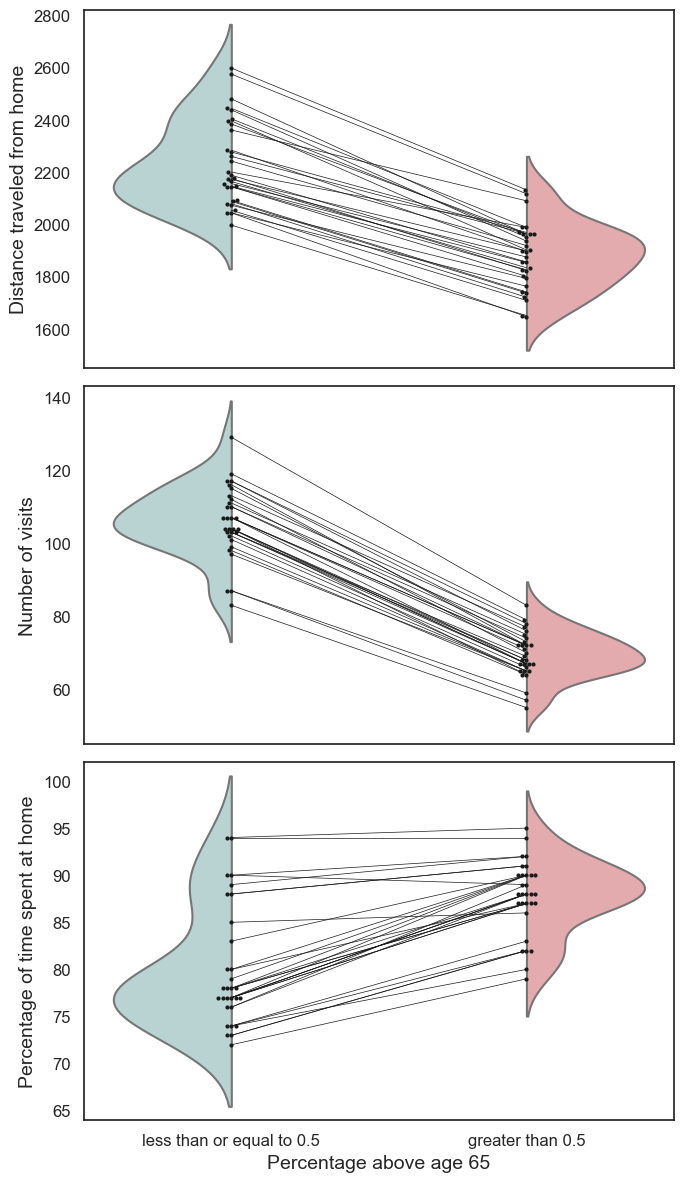

In [590]:
#plot pattern difference using violin plots
colorlist=['#B3D8D5', '#EDA1A4']
colors={'less than or equal to 0.5':'#B3D8D5','greater than 0.5': '#EDA1A4'}
df_all_mob = pd.read_csv('D:/main/1_research/P10_Mobility/p10_aging mobility/results_all_states/MobilityResults/countryLevelData-Figure/US_distribution_mobility_pattern.csv')
fig,ax =plt.subplots(3,1,figsize=(7,12))
ylim_dict={"Distance traveled from home":[1450,2820],"Number of visits":[45,143],"% of Time Spent at Home":[64,102]}

rename_dict={"Distance traveled from home":"Distance traveled from home",
             "Number of visits":"Number of visits",
             "% of Time Spent at Home":"Percentage of time spent at home"}
for i,metric in enumerate(["Distance traveled from home","Number of visits","% of Time Spent at Home"]):
    x1 = []
    x2 = []
    for d in range(30):
        day=d+1
        x1.append(np.median(df_all_mob[(df_all_mob['Percentage above age 65']!='less than or equal to 0.5')&
                   (df_all_mob['Day']==day)][metric]))
        x2.append(np.median(df_all_mob[(df_all_mob['Percentage above age 65']=='less than or equal to 0.5')&
                   (df_all_mob['Day']==day)][metric]))          

    # Create a DataFrame from the data
    df1 = pd.DataFrame({metric: x2, 'Percentage above Age 65': 'less than or equal to 0.5', 'half': np.zeros(len(x1)),
                        'color':'#b3e2cd'})
    df2 = pd.DataFrame({metric: x1, 'Percentage above Age 65': 'greater than 0.5', 'half': np.ones(len(x2)),
                        'color':'#fc8d62'})

    # Combine into one DataFrame
    df = pd.concat([df1, df2]).reset_index()
    df['pair_index'] = list(range(0,30))*2
    #print(df)


    # Create violinplot for x1 and x2
    sns.violinplot(ax=ax[i],x="Percentage above Age 65", y=metric, hue="half", data=df, split=True, inner=None,scale='area',
                  palette=colors.values())

    # Overlay swarmplot on top of violinplot for x1 and x2
    sns.swarmplot(ax=ax[i],x="Percentage above Age 65", y=metric, data=df, color='k', size=3)

    # Get x coordinates for lines
    x_coords = df.groupby('pair_index')['Percentage above Age 65'].apply(list)

    # Get y coordinates for lines
    y_coords = df.groupby('pair_index')[metric].apply(list)

    
    # Draw lines between each pair of points
    for j in range(len(x1)):
        ax[i].plot(x_coords[j], y_coords[j], 'k-', linewidth=0.5)

    # Remove legend
    ax[i].legend().remove()
    ax[i].set_xlim([-0.5,1.5])
    ylow=min(min(x1),min(x2))-5
    yhigh=max(max(x1),max(x2))+5
    ax[i].set_ylim(ylim_dict[metric])   
    
    print(rename_dict[metric],np.median(x1),np.median(x2))
    
    if i<2:
        
        ax[i].set_xlabel('')
        ax[i].set_xticks([])
    else:
        ax[i].set_xlabel('Percentage above age 65', fontsize=14)
        xticks = ax[i].get_xticklabels()

        for tick in xticks:
            tick.set_fontsize(12)  # 
            #tick.set_fontweight('bold')  # 
    ax[i].set_ylabel(rename_dict[metric], fontsize=14)
    
    yticks = ax[i].get_yticklabels() 
    for tick in yticks:
        tick.set_fontsize(12)  # 
        #tick.set_fontweight('bold')  # 


plt.tight_layout()



plt.show()

In [558]:
fig.savefig('D:/main/1_research/P10_Mobility/p10_aging mobility/results_all_states/MobilityResults/countryLevelData-Figure/3metrics_distribution_mobility_pattern.jpg',
            dpi=600,bbox_inches='tight')